In [1]:
# pip install matplotlib_venn

In [2]:
# pip install gensim

In [3]:
# pip install lightgbm

In [4]:
# pip install wordcloud

In [5]:
# pip install tensorflow_hub

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from matplotlib_venn import venn2
from nltk.probability import FreqDist
from scipy.stats import spearmanr
from matplotlib import gridspec
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import plotly.offline as py
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
# import cufflinks as cf
# cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)
import tensorflow as tf
# from transformers import *
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
import tensorflow.keras.backend as K
from tqdm import tqdm
import os

In [8]:
# Reading data
train_data = pd.read_csv('Google Quest/train.csv')
test_data = pd.read_csv('Google Quest/test.csv')
sample_submission = pd.read_csv('Google Quest/sample_submission.csv')

In [9]:
train_data.head(3)

qa_id                                     question_title  \
0      0  What am I losing when using extension tubes in...   
1      1  What is the distinction between a city and a s...   
2      2  Maximum protusion length for through-hole comp...   

                                       question_body question_user_name  \
0  After playing around with macro photography on...               ysap   
1  I am trying to understand what kinds of places...      russellpierce   
2  I'm working on a PCB that has through-hole com...          Joe Baker   

                                  question_user_page  \
0         https://photo.stackexchange.com/users/1024   
1           https://rpg.stackexchange.com/users/8774   
2  https://electronics.stackexchange.com/users/10157   

                                              answer answer_user_name  \
0  I just got extension tubes, so here's the skin...           rfusca   
1  It might be helpful to look into the definitio...     Erik Schmidt   
2  Do you even need grooves?  We make several pro...      Dwayne Reid   

                                    answer_user_page  \
0         https://photo.stackexchange.com/users/1917   
1           https://rpg.stackexchange.com/users/1871   
2  https://electronics.stackexchange.com/users/64754   

                                                 url   category  ...  \
0  http://photo.stackexchange.com/questions/9169/...  LIFE_ARTS  ...   
1  http://rpg.stackexchange.com/questions/47820/w...    CULTURE  ...   
2  http://electronics.stackexchange.com/questions...    SCIENCE  ...   

  question_well_written  answer_helpful  answer_level_of_information  \
0              1.000000        1.000000                     0.666667   
1              0.888889        0.888889                     0.555556   
2              0.777778        0.777778                     0.555556   

   answer_plausible  answer_relevance  answer_satisfaction  \
0          1.000000          1.000000             0.800000   
1          0.888889          0.888889             0.666667   
2          1.000000          1.000000             0.666667   

   answer_type_instructions  answer_type_procedure  \
0                       1.0               0.000000   
1                       0.0               0.000000   
2                       0.0               0.333333   

   answer_type_reason_explanation  answer_well_written  
0                        0.000000             1.000000  
1                        0.666667             0.888889  
2                        1.000000             0.888889  

[3 rows x 41 columns]

In [10]:
print('There are {} rows and {} columns in train'.format(train_data.shape[0],train_data.shape[1]))
print('There are {} rows and {} columns in test'.format(test_data.shape[0],test_data.shape[1]))

There are 6079 rows and 41 columns in train
There are 476 rows and 11 columns in test


In [11]:
train_data.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [12]:
targets = list(sample_submission.columns[1:])
print(len(targets))
targets

30


['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

In [13]:
# Statistical overview of data
train_data[targets].describe()

question_asker_intent_understanding  question_body_critical  \
count                          6079.000000             6079.000000   
mean                              0.892663                0.595301   
std                               0.132047                0.219470   
min                               0.333333                0.333333   
25%                               0.777778                0.444444   
50%                               0.888889                0.555556   
75%                               1.000000                0.777778   
max                               1.000000                1.000000   

       question_conversational  question_expect_short_answer  \
count              6079.000000                   6079.000000   
mean                  0.057301                      0.698525   
std                   0.182196                      0.350938   
min                   0.000000                      0.000000   
25%                   0.000000                      0.500000   
50%                   0.000000                      0.666667   
75%                   0.000000                      1.000000   
max                   1.000000                      1.000000   

       question_fact_seeking  question_has_commonly_accepted_answer  \
count            6079.000000                            6079.000000   
mean                0.772633                               0.793689   
std                 0.303023                               0.336622   
min                 0.000000                               0.000000   
25%                 0.666667                               0.666667   
50%                 1.000000                               1.000000   
75%                 1.000000                               1.000000   
max                 1.000000                               1.000000   

       question_interestingness_others  question_interestingness_self  \
count                      6079.000000                    6079.000000   
mean                          0.587478                       0.507275   
std                           0.135900                       0.185987   
min                           0.333333                       0.333333   
25%                           0.444444                       0.333333   
50%                           0.555556                       0.444444   
75%                           0.666667                       0.666667   
max                           1.000000                       1.000000   

       question_multi_intent  question_not_really_a_question  ...  \
count            6079.000000                     6079.000000  ...   
mean                0.238745                        0.004469  ...   
std                 0.335057                        0.045782  ...   
min                 0.000000                        0.000000  ...   
25%                 0.000000                        0.000000  ...   
50%                 0.000000                        0.000000  ...   
75%                 0.333333                        0.000000  ...   
max                 1.000000                        1.000000  ...   

       question_well_written  answer_helpful  answer_level_of_information  \
count            6079.000000     6079.000000                  6079.000000   
mean                0.799931        0.925408                     0.654823   
std                 0.178420        0.114836                     0.107666   
min                 0.333333        0.333333                     0.333333   
25%                 0.666667        0.888889                     0.666667   
50%                 0.833333        1.000000                     0.666667   
75%                 1.000000        1.000000                     0.666667   
max                 1.000000        1.000000                     1.000000   

       answer_plausible  answer_relevance  answer_satisfaction  \
count       6079.000000       6079.000000          6079.000000   
mean           0.960054          0.968626            

In [14]:
# checking missing value in train data
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending = False)
missing_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

Total  Percent
answer_well_written                        0      0.0
question_multi_intent                      0      0.0
question_interestingness_others            0      0.0
question_has_commonly_accepted_answer      0      0.0
question_fact_seeking                      0      0.0

In [15]:
# checking missing value in test data
total = test_data.isnull().sum().sort_values(ascending = False)
percent = (test_data.isnull().sum()/test_data.isnull().count()*100).sort_values(ascending = False)
missing_test_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_test_data.head()

Total  Percent
host                  0      0.0
category              0      0.0
url                   0      0.0
answer_user_page      0      0.0
answer_user_name      0      0.0

## Exploratory Data Analysis

In [16]:
train_data['host'].nunique()

63

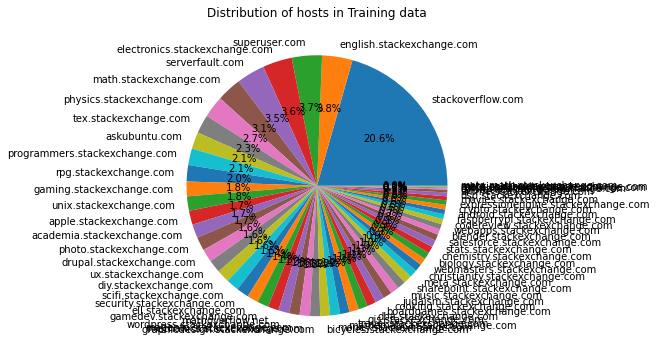

In [17]:
plt.figure(figsize=(12,6))
temp = train_data['host'].value_counts()
df = pd.DataFrame({'labels': temp.index, 'values': temp.values})
plt.pie(df['values'], labels=df['labels'], autopct='%1.1f%%')
plt.title('Distribution of hosts in Training data')
plt.show()

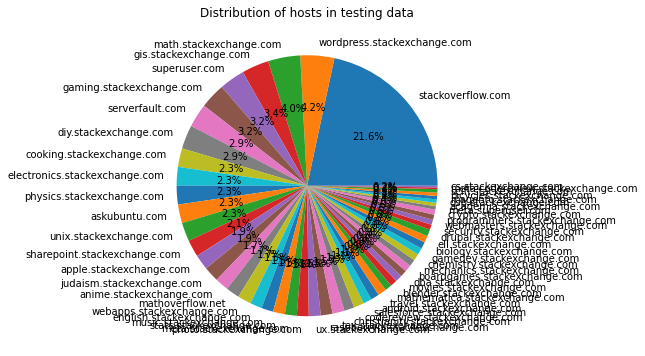

In [18]:
plt.figure(figsize=(12,6))
temp = test_data['host'].value_counts()
df = pd.DataFrame({'labels': temp.index, 'values': temp.values})
plt.pie(df['values'], labels=df['labels'], autopct='%1.1f%%')
plt.title('Distribution of hosts in testing data')
plt.show()

**Conclusion:**
- In Training DataSet Stackoverflow.com from which most website Question & Answers collected over 20.6%.
- In Testing DataSet Stackoverflow.com from which most website Question & Answers collected over 21.6%.

### Class distribution

In [19]:
temp = train_data["category"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Distribution of categories in training data in % ",
    xaxis=dict(
        title='category',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='test')

In [20]:
temp = test_data["category"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
 x = temp.index,
 y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
 title = "Distribution of categories in test data in % ",
 xaxis=dict(
 title='category',
 tickfont=dict(
 size=14,
 color='rgb(107, 107, 107)'
 )
 ),
 yaxis=dict(
 title='Count in %',
 titlefont=dict(
 size=16,
 color='rgb(107, 107, 107)'
 ),
 tickfont=dict(
 size=14,
 color='rgb(107, 107, 107)'
 )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='test')

**Conclusion:**
- Distribution of Categories is a Categorical Data conatin Technology, StackoverFlow, Culture , Science and Life arts.
- Technology and Stackoverflow has contributed Maximum in training as well as Testing Data set.
- Technology = 40% in Training data set and 42.85 % in testing Data set.

### Distribution of Target variables

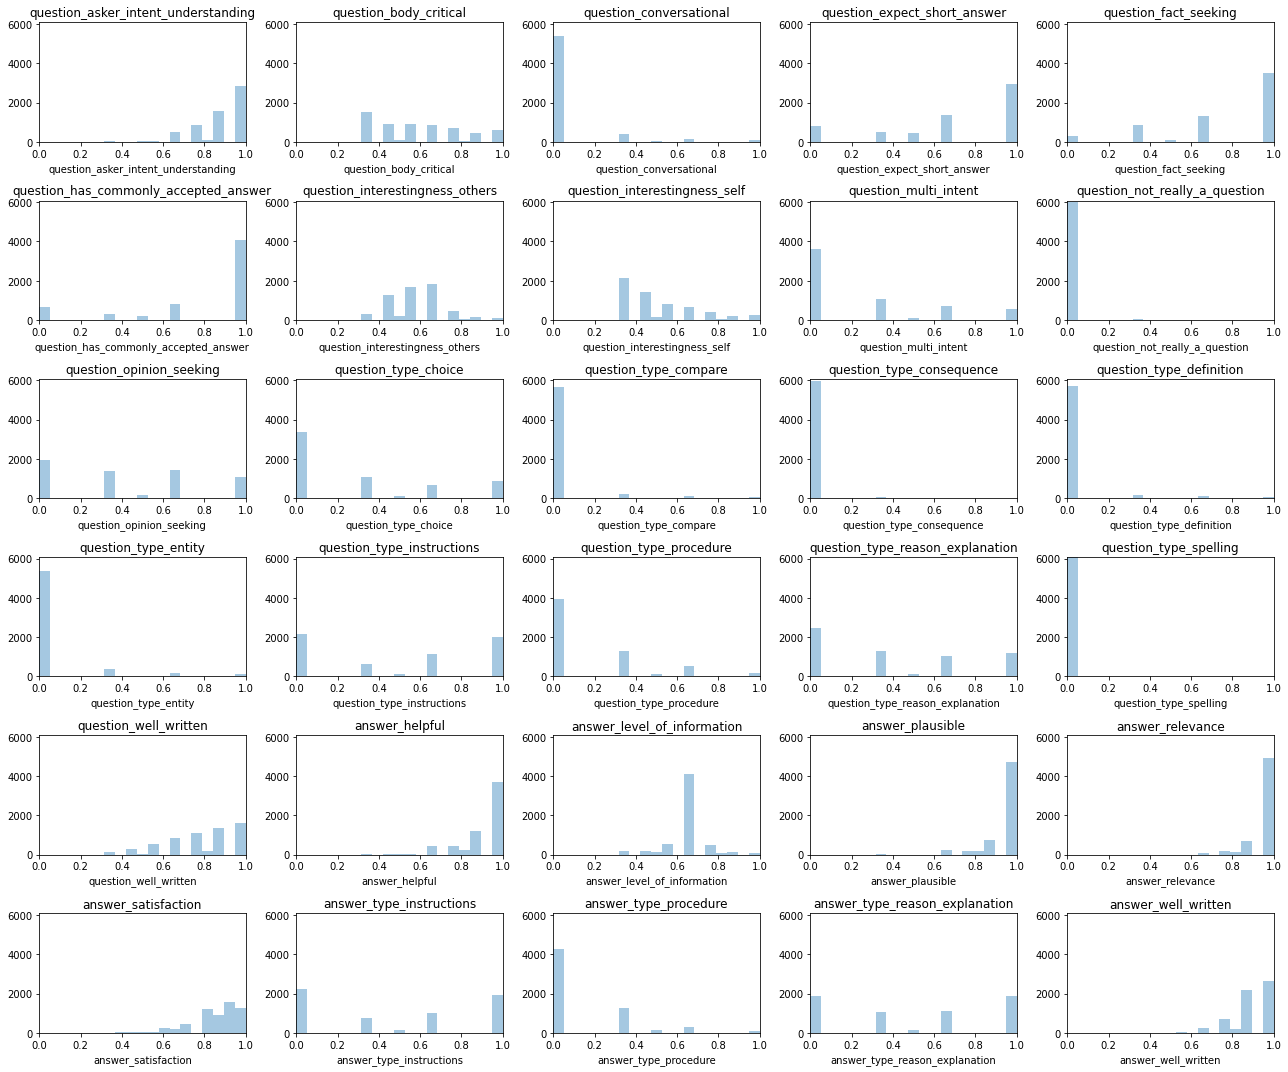

In [21]:
fig, axes = plt.subplots(6, 5, figsize=(18, 15))
axes = axes.ravel()
bins = np.linspace(0, 1, 20)
for i, col in enumerate(targets):
 ax = axes[i]
 sns.distplot(train_data[col], label=col, kde=False, bins=bins, ax=ax)
 ax.set_title(col)
 ax.set_xlim([0, 1])
 ax.set_ylim([0, 6079])
plt.tight_layout()
plt.show()
plt.close()

### Venn Diagram(Common Features values in training and test data)

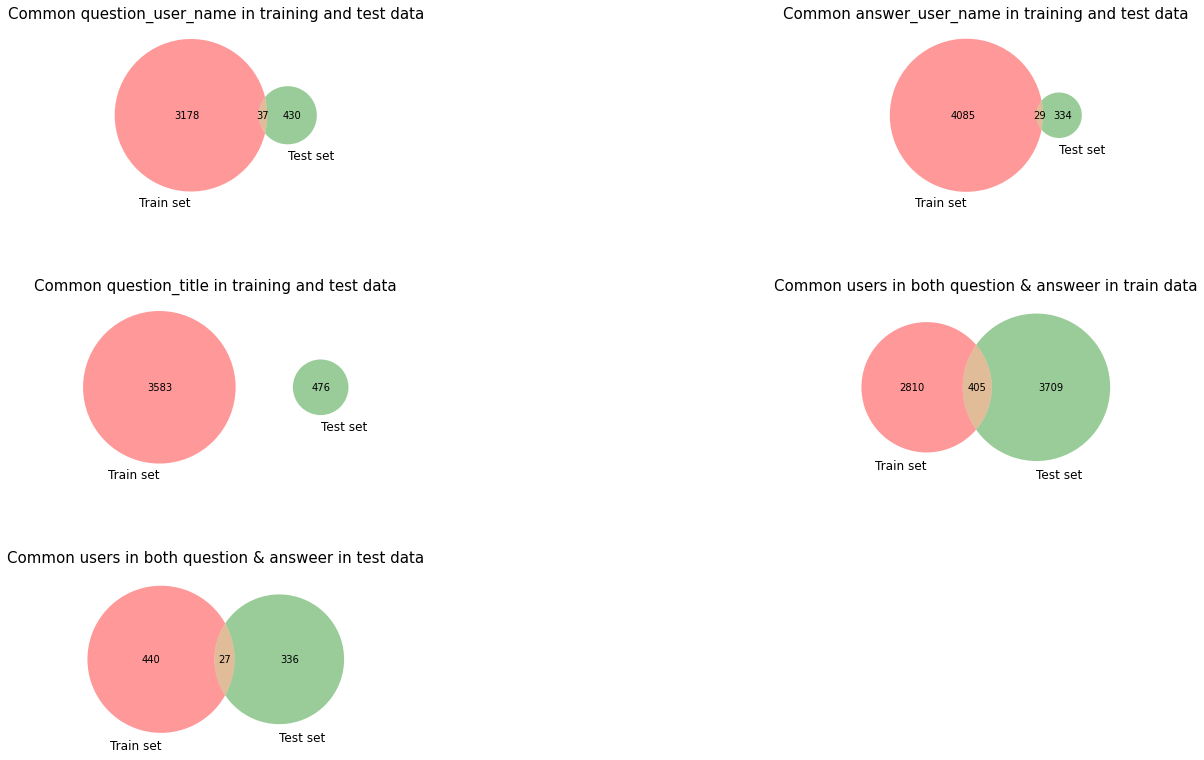

In [22]:
plt.figure(figsize=(23,13))

plt.subplot(321)
venn2([set(train_data.question_user_name.unique()), set(test_data.question_user_name.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common question_user_name in training and test data", fontsize=15)

plt.subplot(322)
venn2([set(train_data.answer_user_name.unique()), set(test_data.answer_user_name.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common answer_user_name in training and test data", fontsize=15)

plt.subplot(323)
venn2([set(train_data.question_title.unique()), set(test_data.question_title.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common question_title in training and test data", fontsize=15)

plt.subplot(324)
venn2([set(train_data.question_user_name.unique()), set(train_data.answer_user_name.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common users in both question & answeer in train data", fontsize=15)

plt.subplot(325)
venn2([set(test_data.question_user_name.unique()), set(test_data.answer_user_name.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common users in both question & answeer in test data", fontsize=15)

plt.subplots_adjust(wspace = 0.5, hspace = 0.5,
                    top = 0.9)
plt.show()

**Conclusion:**
- Above Ven diagram shows that common feature in training and testing data set.
- There no common question_title present in traning and testing dataset.i.e all question title is unique in testing dataset.
- The Most common Feature present in training as well as testing is answer_user_name is 405.

### Distribution for Question Title

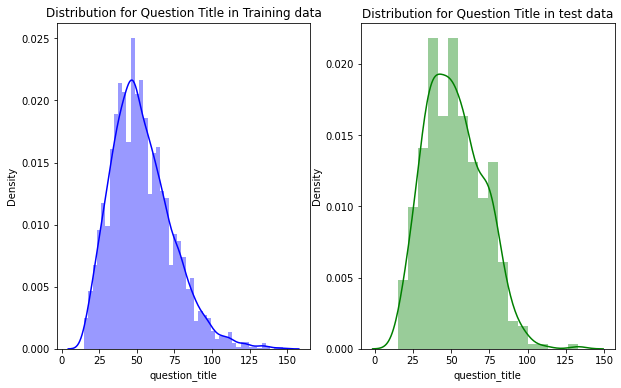

In [23]:
train_question_title=train_data['question_title'].str.len()
test_question_title=test_data['question_title'].str.len()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(train_question_title,ax=ax1,color='blue')
sns.distplot(test_question_title,ax=ax2,color='green')
ax2.set_title('Distribution for Question Title in test data')
ax1.set_title('Distribution for Question Title in Training data')
plt.show()

**Conclusion:**
- Question title having Number of wods lies between 25 to 75 contribtes more in training as well as testing dataset.

### Distribution for Question body

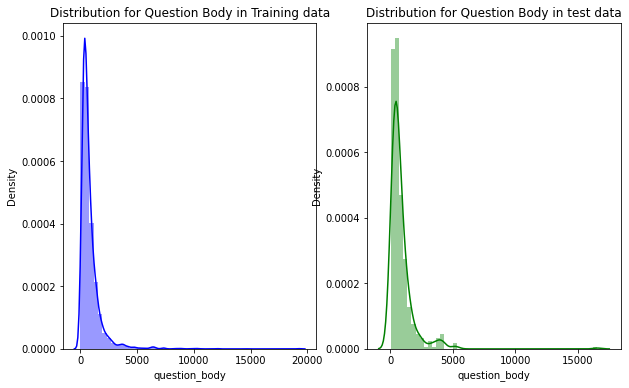

In [24]:
train_question_title=train_data['question_body'].str.len()
test_question_title=test_data['question_body'].str.len()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(train_question_title,ax=ax1,color='blue')
sns.distplot(test_question_title,ax=ax2,color='green')
ax2.set_title('Distribution for Question Body in test data')
ax1.set_title('Distribution for Question Body in Training data')
plt.show()

**Conclusion:**
- Question Body having Number of wods lies between 300 to 500 contribtes more in training as well as testing dataset.

### Distribution for Answers


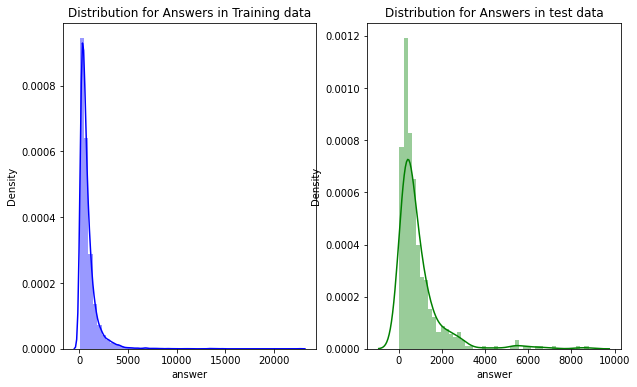

In [25]:
train_question_title=train_data['answer'].str.len()
test_question_title=test_data['answer'].str.len()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(train_question_title,ax=ax1,color='blue')
sns.distplot(test_question_title,ax=ax2,color='green')
ax2.set_title('Distribution for Answers in test data')
ax1.set_title('Distribution for Answers in Training data')
plt.show()

**Conclusion:**
- Question Answer having Number of wods lies between 300 to 500 contribtes more in training as well as testing dataset.

### Duplicate Questions Title & Most popular Questions

In [26]:
# Duplicate Questions
print("Number of duplicate questions in descending order")
print("------------------------------------------------------")
train_data.groupby('question_title').count()['qa_id'].sort_values(ascending=False).head(25)

Number of duplicate questions in descending order
------------------------------------------------------


question_title
What is the best introductory Bayesian statistics textbook?                        12
What does mathematics have to do with programming?                                 11
Important non-technical course for programmers?                                    11
How to prevent the "Too awesome to use" syndrome                                    9
Another instructor is pushing me out of the classroom right after my class ends     7
No sound in Ubuntu except at log in                                                 7
How do I deal with a slow and undedicated colleague in the team?                    7
What are the benefits of owning a physical book?                                    7
House rules to make the cloister less of a game winning tile in Carcassonne?        6
Making sure that you have comprehended a concept                                    6
hide javascript/jquery scripts from html page?                                      6
What is the best place to start Warhamm

In [27]:
# Most popular question
train_data[train_data['question_title'] == 'What is the best introductory Bayesian statistics textbook?']

qa_id                                     question_title  \
229     366  What is the best introductory Bayesian statist...   
1616   2536  What is the best introductory Bayesian statist...   
1647   2591  What is the best introductory Bayesian statist...   
2104   3349  What is the best introductory Bayesian statist...   
3476   5543  What is the best introductory Bayesian statist...   
3762   5989  What is the best introductory Bayesian statist...   
3801   6041  What is the best introductory Bayesian statist...   
3899   6215  What is the best introductory Bayesian statist...   
4408   7003  What is the best introductory Bayesian statist...   
5239   8328  What is the best introductory Bayesian statist...   
5587   8867  What is the best introductory Bayesian statist...   
5766   9137  What is the best introductory Bayesian statist...   

                                          question_body question_user_name  \
229   Which is the best introductory textbook for Ba...              Shane   
1616  Which is the best introductory textbook for Ba...              Shane   
1647  Which is the best introductory textbook for Ba...              Shane   
2104  Which is the best introductory textbook for Ba...              Shane   
3476  Which is the best introductory textbook for Ba...              Shane   
3762  Which is the best introductory textbook for Ba...              Shane   
3801  Which is the best introductory textbook for Ba...              Shane   
3899  Which is the best introductory textbook for Ba...              Shane   
4408  Which is the best introductory textbook for Ba...              Shane   
5239  Which is the best introductory textbook for Ba...              Shane   
5587  Which is the best introductory textbook for Ba...              Shane   
5766  Which is the best introductory textbook for Ba...              Shane   

                           question_user_page  \
229   https://stats.stackexchange.com/users/5   
1616  https://stats.stackexchange.com/users/5   
1647  https://stats.stackexchange.com/users/5   
2104  https://stats.stackexchange.com/users/5   
3476  https://stats.stackexchange.com/users/5   
3762  https://stats.stackexchange.com/users/5   
3801  https://stats.stackexchange.com/users/5   
3899  https://stats.stackexchange.com/users/5   
4408  https://stats.stackexchange.com/users/5   
5239  https://stats.stackexchange.com/users/5   
5587  https://stats.stackexchange.com/users/5   
5766  https://stats.stackexchange.com/users/5   

                                                 answer  answer_user_name  \
229   "Bayesian Core: A Practical Approach to Comput...             gappy   
1616  I am now reading : From Algorithm to Z-Scores:...             Fabio   
1647  My favorite is "Bayesian Data Analysis" by Gel...             Shane   
2104  I have read some parts of A First Course in Ba...     George Dontas   
3476  Sivia and Skilling, Data analysis: a Bayesian ...             denis   
3762  If I had to choose a single text for a beginne...         Jim Stone   
3801  Take a look at "The Bayesian Choice". It has t...               Zen   
3899  I found an excellent introduction in Gelman an...       Jack Tanner   
4408  Its focus isn't strictly on Bayesian statistic...               Joe   
5239  I read:\n\nGelman et al (2013). Bayesian Data ...     stochazesthai   
5587  Not strictly Bayesian Statistics as such, but ...  Dikran Marsupial   
5766  Coming from non-statistical background I found...             radek   

                                 answer_user_page  \
229      https://stats.stackexchange.com/users/30   
1616  https://stats.stackexchange.com/users/40316   
1647      https://stats.stackexchange.com/users/5   
2104    https://stats.stackexchange.com/users/339   
3476    https://stats.stackexchange.com/users/557   
3762  https://stats.stackexchange.com/users/26779   
3801   https://stats.stackexchange.com/users/9394   
3899   https://stats.stackexchange.com/users/8207   
4408   https://

### WordClouds by Categories

In [28]:
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm
comment_words = ' '
stopwords = set(STOPWORDS)
for val in tqdm(train_data[train_data['category'] =='TECHNOLOGY']['answer'].astype(str)):
    val = str(val)

    # split the value
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

100%|██████████████████████████████████████████████████████████████████████████████| 2441/2441 [04:04<00:00,  9.99it/s]


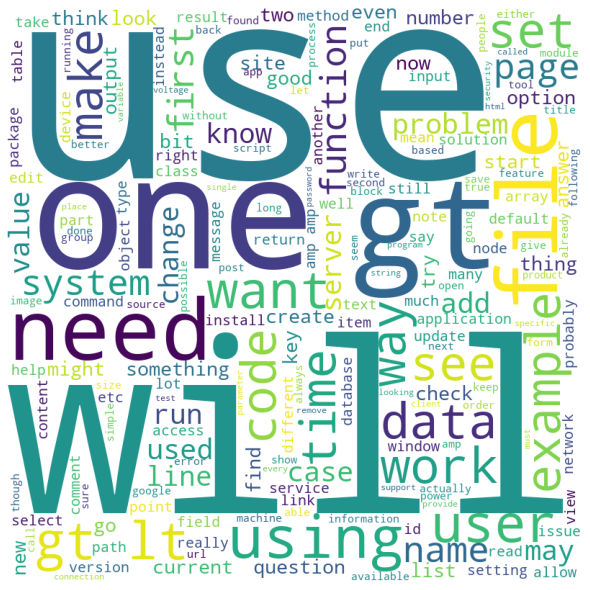

In [29]:
wordcloud = WordCloud(width = 800, height = 800,
background_color ='white',
stopwords = stopwords,
min_font_size = 10).generate(comment_words)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [30]:
comment_words = ' '
stopwords = set(STOPWORDS)
for val in tqdm(train_data[train_data['category'] =='STACKOVERFLOW']['answer'].astype(str)):
    val = str(val)

    # split the value
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

100%|██████████████████████████████████████████████████████████████████████████████| 1253/1253 [00:20<00:00, 62.39it/s]


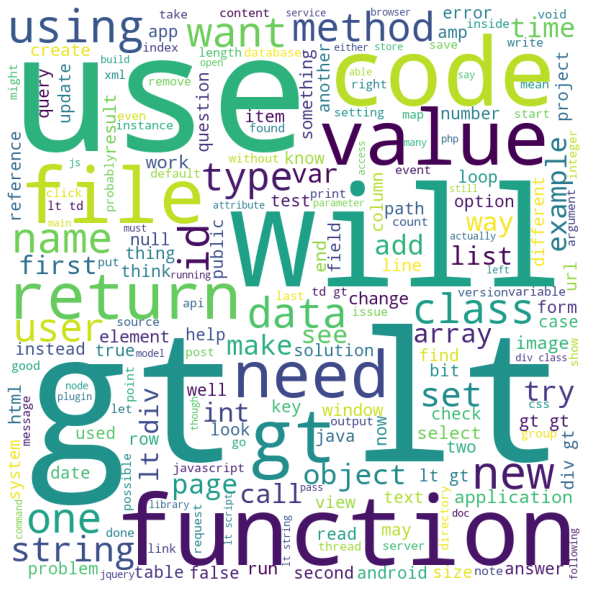

In [31]:
wordcloud = WordCloud(width = 800, height = 800,
background_color ='white',
stopwords = stopwords,
min_font_size = 10).generate(comment_words)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [32]:
comment_words = ' '
stopwords = set(STOPWORDS)
for val in tqdm(train_data[train_data['category'] =='CULTURE']['answer'].astype(str)):
    val = str(val)

    # split the value
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

100%|████████████████████████████████████████████████████████████████████████████████| 963/963 [00:36<00:00, 26.31it/s]


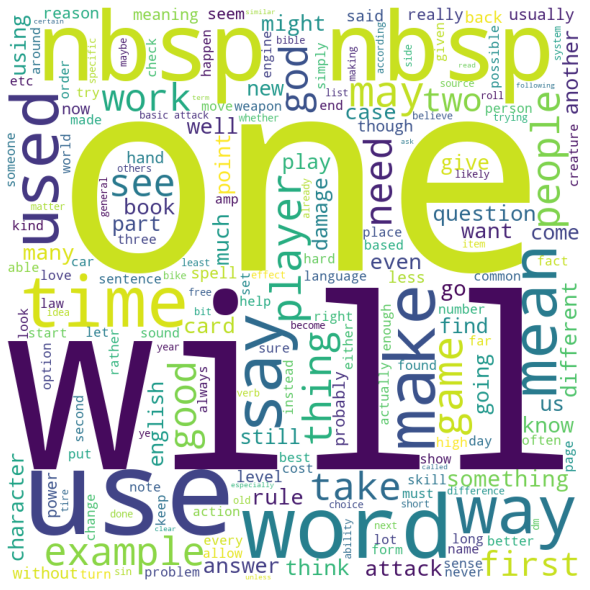

In [33]:
wordcloud = WordCloud(width = 800, height = 800,
background_color ='white',
stopwords = stopwords,
min_font_size = 10).generate(comment_words)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [34]:
comment_words = ' '
stopwords = set(STOPWORDS)
for val in tqdm(train_data[train_data['category'] =='SCIENCE']['answer'].astype(str)):
    val = str(val)

    # split the value
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

100%|████████████████████████████████████████████████████████████████████████████████| 713/713 [00:15<00:00, 44.72it/s]


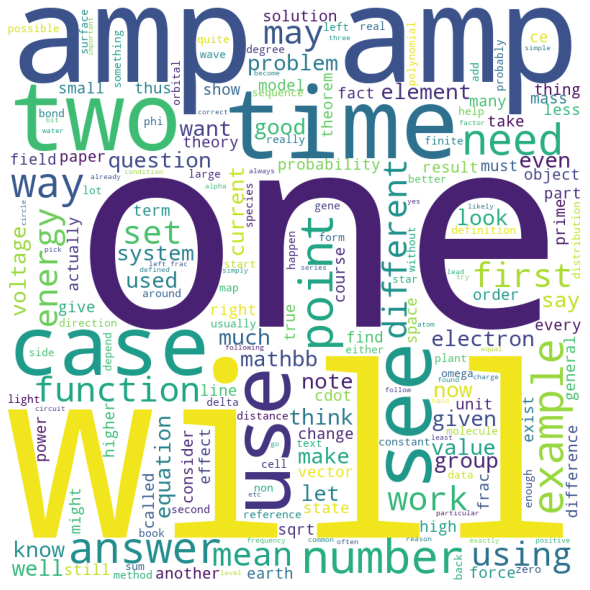

In [35]:
wordcloud = WordCloud(width = 800, height = 800,
background_color ='white',
stopwords = stopwords,
min_font_size = 10).generate(comment_words)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [36]:
comment_words = ' '
stopwords = set(STOPWORDS)
for val in tqdm(train_data[train_data['category'] =='LIFE_ARTS']['answer'].astype(str)):
    val = str(val)

    # split the value
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

100%|████████████████████████████████████████████████████████████████████████████████| 709/709 [00:17<00:00, 40.60it/s]


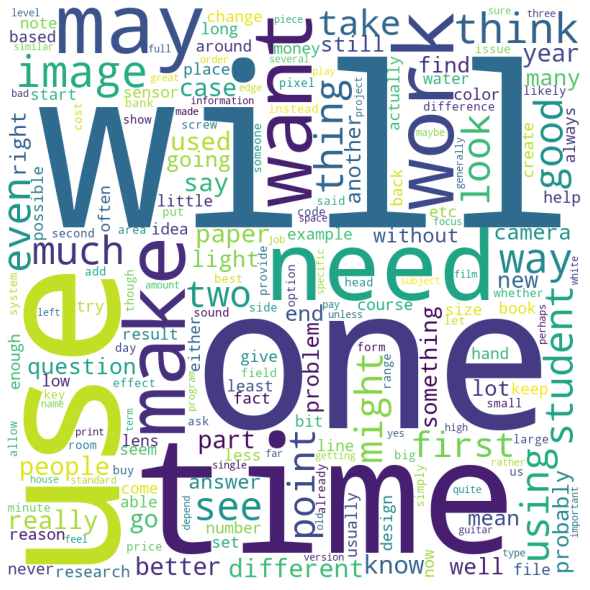

In [37]:
wordcloud = WordCloud(width = 800, height = 800,
background_color ='white',
stopwords = stopwords,
min_font_size = 10).generate(comment_words)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [38]:
# mispell_dict = {"aren't" : "are not",
#                 "can't" : "cannot",
#                 "couldn't" : "could not",
#                 "couldnt" : "could not",
#                 "didn't" : "did not",
#                 "doesn't" : "does not",
#                 "doesnt" : "does not",
#                 "don't" : "do not",
#                 "hadn't" : "had not",
#                 "hasn't" : "has not",
#                 "haven't" : "have not",
#                 "havent" : "have not",
#                 "he'd" : "he would",
#                 "he'll" : "he will",
#                 "he's" : "he is",
#                 "i'd" : "I would",
#                 "i'd" : "I had",
#                 "i'll" : "I will",
#                 "i'm" : "I am",
#                 "isn't" : "is not",
#                 "it's" : "it is",
#                 "it'll":"it will",
#                 "i've" : "I have",
#                 "let's" : "let us",
#                 "mightn't" : "might not",
#                 "mustn't" : "must not",
#                 "shan't" : "shall not",
#                 "she'd" : "she would",
#                 "she'll" : "she will",
#                 "she's" : "she is",
#                 "shouldn't" : "should not",
#                 "shouldnt" : "should not",
#                 "that's" : "that is",
#                 "thats" : "that is",
#                 "there's" : "there is",
#                 "theres" : "there is",
#                 "they'd" : "they would",
#                 "they'll" : "they will",
#                 "they're" : "they are",
#                 "theyre": "they are",
#                 "they've" : "they have",
#                 "we'd" : "we would",
#                 "we're" : "we are",
#                 "weren't" : "were not",
#                 "we've" : "we have",
#                 "what'll" : "what will",
#                 "what're" : "what are",
#                 "what's" : "what is",
#                 "what've" : "what have",
#                 "where's" : "where is",
#                 "who'd" : "who would",
#                 "who'll" : "who will",
#                 "who're" : "who are",
#                 "who's" : "who is",
#                 "who've" : "who have",
#                 "won't" : "will not",
#                 "wouldn't" : "would not",
#                 "you'd" : "you would",
#                 "you'll" : "you will",
#                 "you're" : "you are",
#                 "you've" : "you have",
#                 "'re": " are",
#                 "wasn't": "was not",
#                 "we'll":" will",
#                 "didn't": "did not",
#                 "tryin'":"trying"}

# def clean_text(text):
#     text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
#     text = text.lower().split()
#     stopwords = set(STOPWORDS)
#     # stops = set(stopwords.words("english"))
#     text = [w for w in text if not w in stopwords]
#     text = " ".join(text)
#     return(text)

# def _get_mispell(mispell_dict):
#     mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
#     return mispell_dict, mispell_re

# def replace_typical_misspell(text):
#     mispellings, mispellings_re = _get_mispell(mispell_dict)

# def replace(match):
#     return mispellings[match.group(0)]
#     return mispellings_re.sub(replace, text)

# def clean_data(df, columns: list):
#     for col in columns:
#         df[col] = df[col].apply(lambda x: clean_text(x.lower()))
#         df[col] = df[col].apply(lambda x: replace_typical_misspell(x))
#         return df


In [39]:
# columns = ['question_title','question_body','answer']
# train_data = clean_data(train_data, columns)
# test_data = clean_data(test_data, columns)

### Distribution for Word frequency

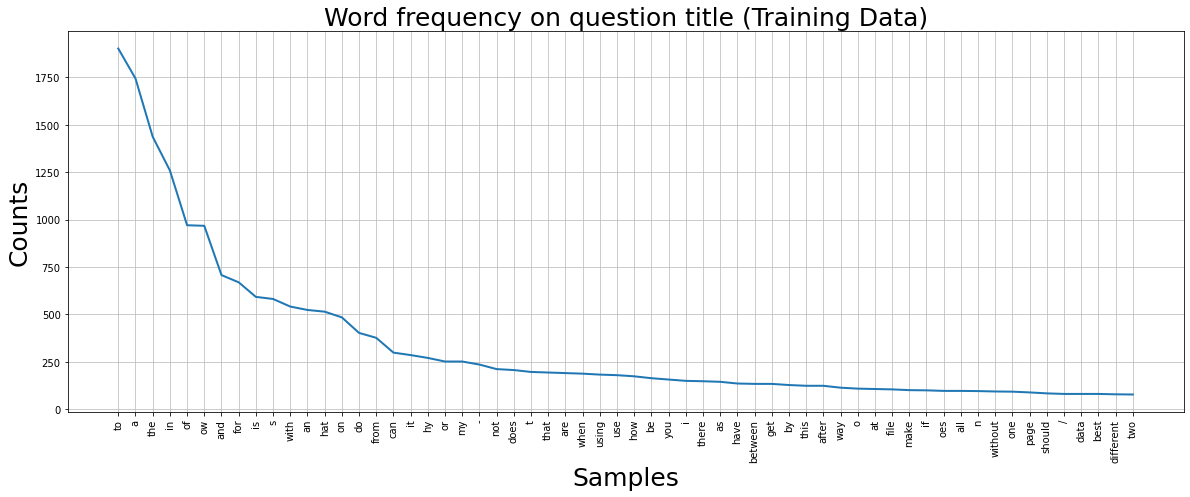

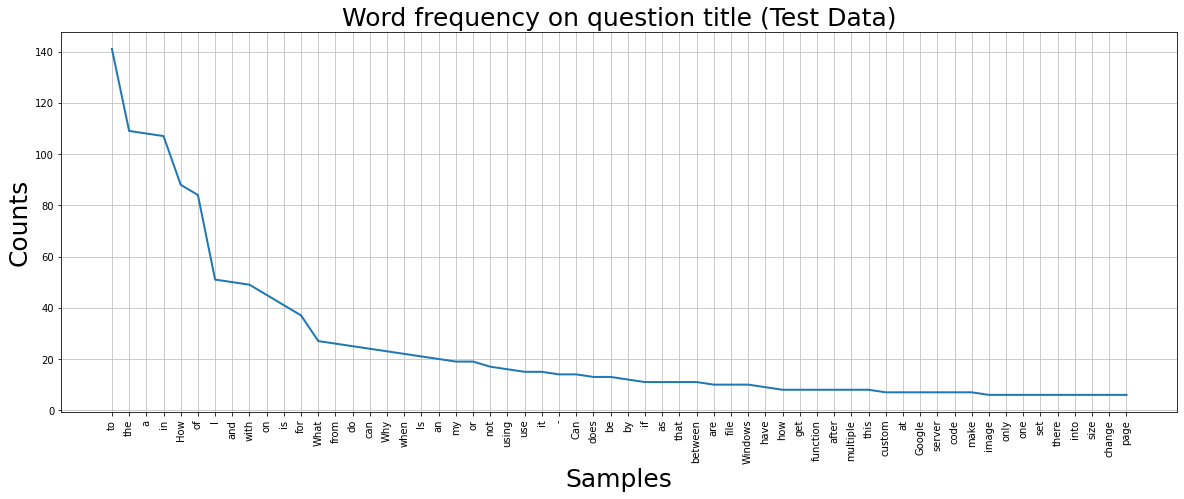

In [40]:
# training data
freq_dist = FreqDist([word for text in train_data['question_title'].str.replace('[^a-za-z0-9^,!.\/+-=]',' ') for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question title (Training Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()
# test data
freq_dist = FreqDist([word for text in test_data['question_title'] for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question title (Test Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

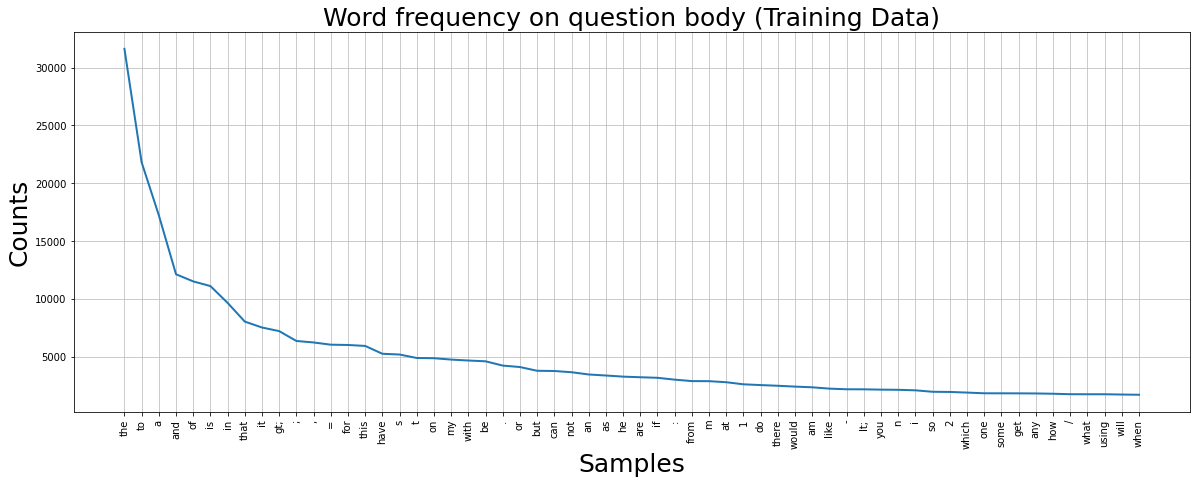

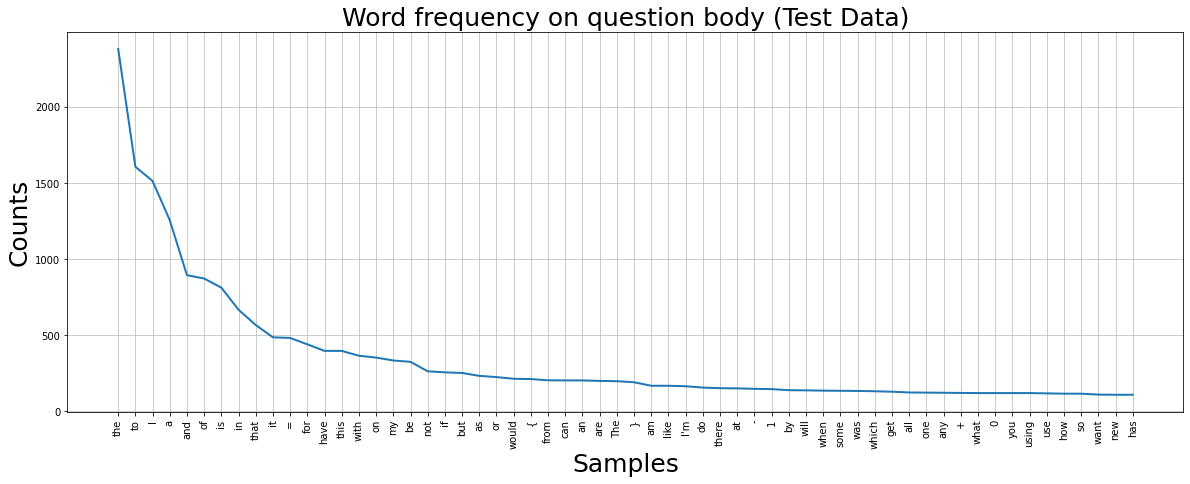

In [41]:
# training data
freq_dist = FreqDist([word for text in train_data['question_body'].str.replace('[^a-za-z0-9^,!.\/+-=]',' ') for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question body (Training Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()
# test data
freq_dist = FreqDist([word for text in test_data['question_body'] for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on question body (Test Data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

### Distribution of all Target Features

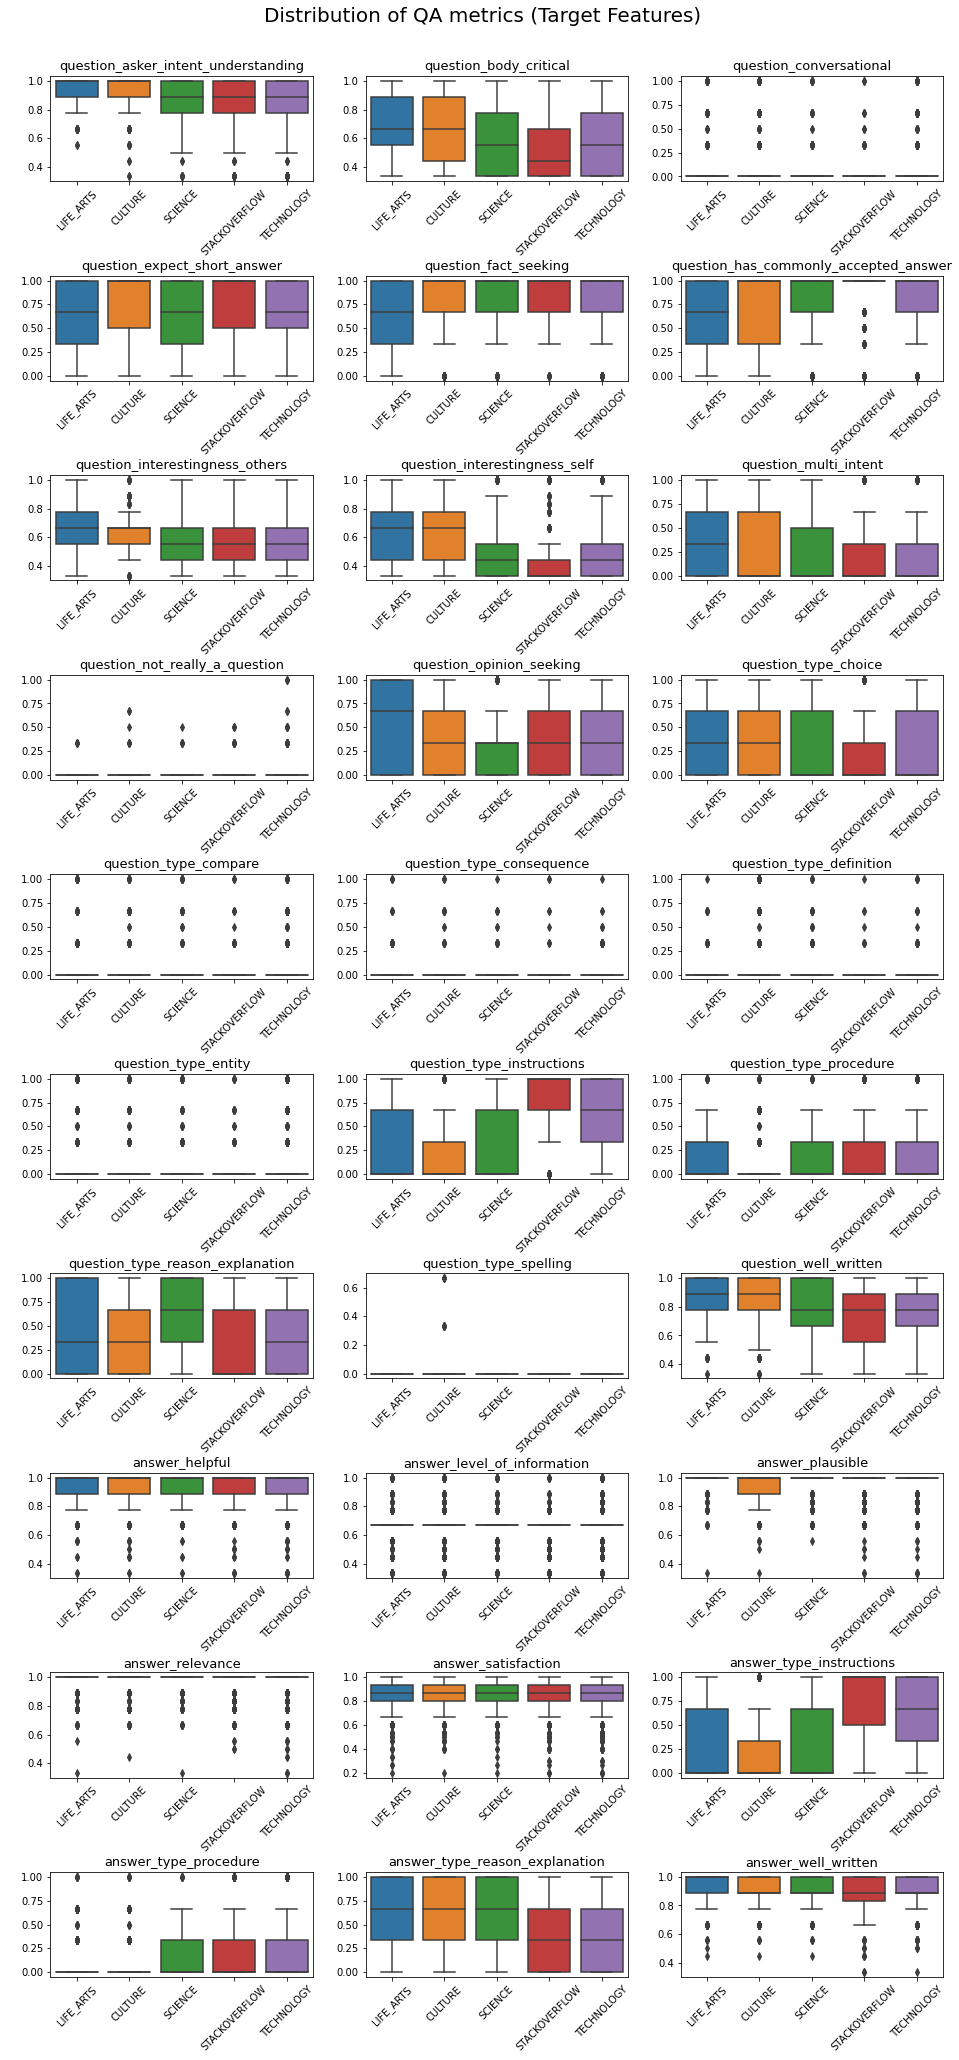

In [42]:
grid = gridspec.GridSpec(10, 3)
target_columns = list(sample_submission.columns)[1:]
plt.figure(figsize=(16,8*4))
count=0
plt.suptitle('Distribution of QA metrics (Target Features)', size=20)
# top_host = df_train['host_cat'].value_counts()[:15].index
for n, col in enumerate(target_columns):
    ax = plt.subplot(grid[count])
    sns.boxplot(x='category', y=col, data=train_data)
    ax.set_title(str(col), fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel(' ')
    count+=1
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.subplots_adjust(top = 0.95, hspace=.9, wspace=.2)
plt.show()

**Conclusion:**
- The above plot a informative chart where we can get the difference between the categories to each target feature.
- "question_body_critical" has an interesting distribution between the different categories has lot of variation.
- "question_asker_intent_understanding" doesn't show lot varition vs catrgory all 25-75 percentile is same only.
- Target Variable "question_not_really_question" show lot of varition against category.
- Rest all variable does not have very much variance.

### Variable Correlations


In [43]:
import re
question_related_target_cols = [ col for col in target_columns if re.search('^question_', col)]
answer_related_target_cols = [ col for col in target_columns if re.search('^answer_', col)]

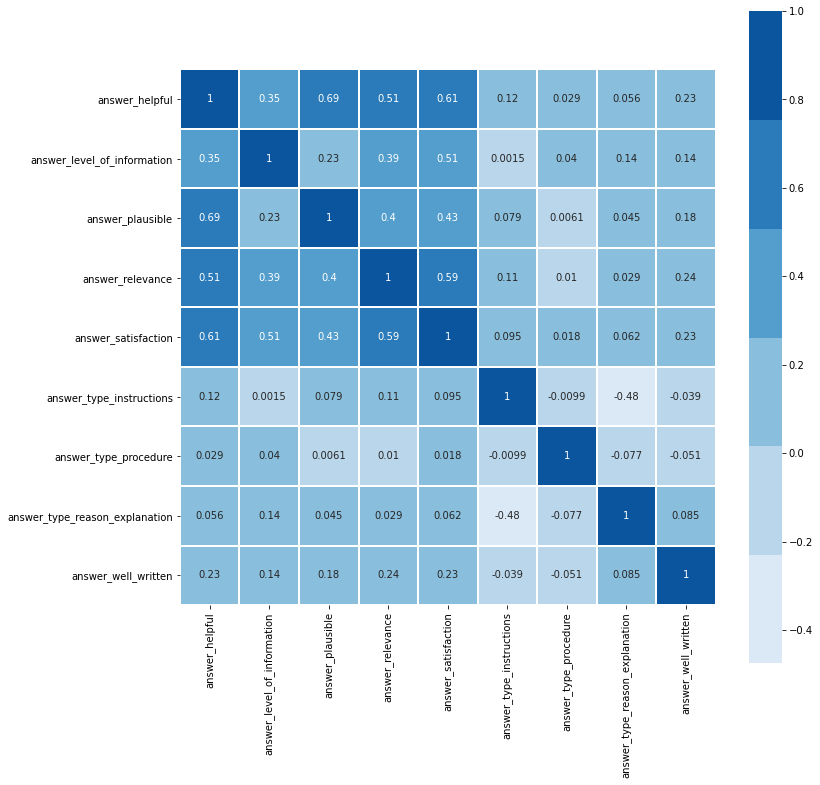

In [44]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=train_data[answer_related_target_cols].corr(),
         square=True,
         annot=True,
         linewidths=1,
         cmap=sns.color_palette("Blues"))
plt.show()

**Conclusion:**
- The above variable correlation heat map "answer_related_target_cols" describe how answer related the feature related with each other.
- As Answer plausable and answer helpfull is very Related with Each other.

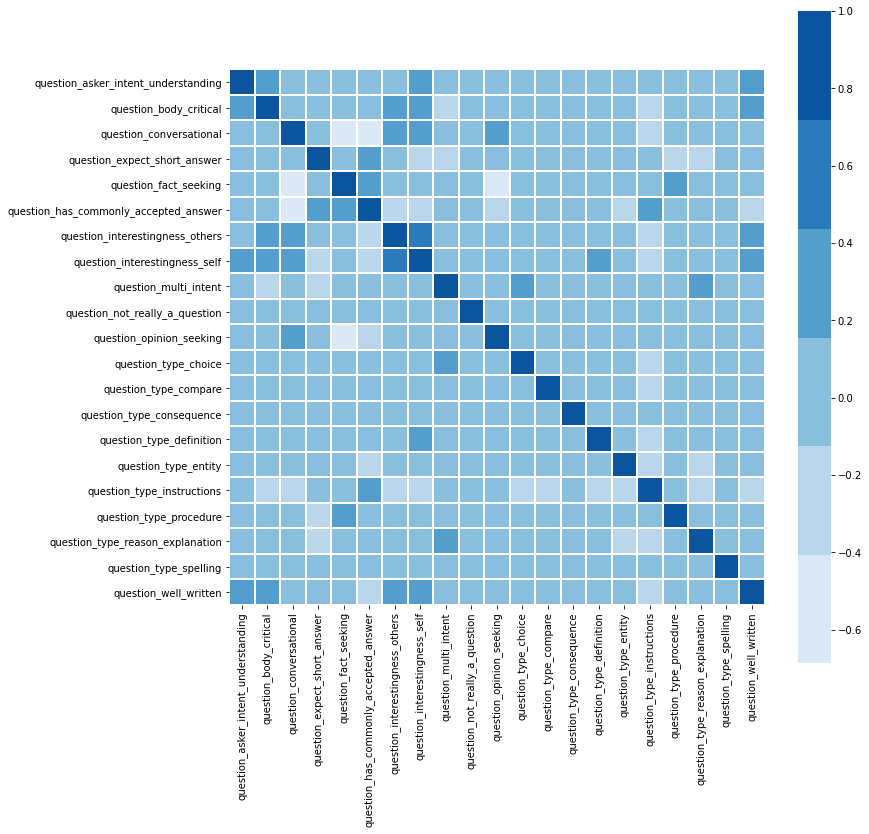

In [45]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=train_data[question_related_target_cols].corr(),
         square=True,
         linewidths=1,
         cmap=sns.color_palette("Blues"))
plt.show()

**Conclusion:**
- The above variable correlation heat map question_related_target_cols describe how question related the feature related with each other
- As question instrestingness self and question instrestingness other is very Related with Each other.

## Feature Engineering


- Number of characters in the question_title
- Number of characters in the question_body
- Number of characters in the answer
- Number of words in the question_title
- Number of words in the question_body
- Number of words in the answer
- Number of unique words in the question_title
- Number of unique words in the question_body
- Number of unique words in the answer

In [46]:
# Number of characters in the text
train_data["question_title_num_chars"] = train_data["question_title"].apply(lambda x: len(str(x).split()))
train_data["question_body_num_chars"] = train_data["question_body"].apply(lambda x: len(str(x).split()))
train_data["answer_num_chars"] = train_data["answer"].apply(lambda x: len(str(x)))
test_data["question_title_num_chars"] = test_data["question_title"].apply(lambda x: len(str(x).split()))
test_data["question_body_num_chars"] = test_data["question_body"].apply(lambda x: len(str(x).split()))
test_data["answer_num_chars"] = test_data["answer"].apply(lambda x: len(str(x)))
# Number of words in the text
train_data["question_title_num_words"] = train_data["question_title"].apply(lambda x: len(str(x).split()))
train_data["question_body_num_words"] = train_data["question_body"].apply(lambda x: len(str(x).split()))
train_data["answer_num_words"] = train_data["answer"].apply(lambda x: len(str(x).split()))
test_data["question_title_num_words"] = test_data["question_title"].apply(lambda x: len(str(x).split()))
test_data["question_body_num_words"] = test_data["question_body"].apply(lambda x: len(str(x).split()))
test_data["answer_num_words"] = test_data["answer"].apply(lambda x: len(str(x).split()))
# Number of unique words in the text
train_data["question_title_num_unique_words"] = train_data["question_title"].apply(lambda x: len(str(x).split()))
train_data["question_body_num_unique_words"] = train_data["question_body"].apply(lambda x: len(str(x).split()))
train_data["answer_num_unique_words"] = train_data["answer"].apply(lambda x: len(str(x).split()))
test_data["question_title_num_unique_words"] = test_data["question_title"].apply(lambda x: len(str(x).split()))
test_data["question_body_num_unique_words"] = test_data["question_body"].apply(lambda x: len(str(x).split()))
test_data["answer_num_unique_words"] = test_data["answer"].apply(lambda x: len(str(x).split()))

### Data Preprocessing

In [47]:
target_columns = list(sample_submission.columns)[1:]

In [48]:
print(len(target_columns))
print(target_columns)

30
['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']


In [49]:
final_dataset = train_data.drop(target_columns, axis=1)
final_dataset_target = train_data[target_columns].copy()

In [50]:
print(final_dataset.shape)
print(final_dataset_target.shape)

(6079, 20)
(6079, 30)


In [51]:
final_dataset.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_title_num_chars',
       'question_body_num_chars', 'answer_num_chars',
       'question_title_num_words', 'question_body_num_words',
       'answer_num_words', 'question_title_num_unique_words',
       'question_body_num_unique_words', 'answer_num_unique_words'],
      dtype='object')

### Data Preprocessing question_title

In [52]:
# Removing HTML Tag , \r tags, \n (enter) with space Removed all Special Character
from tqdm import tqdm
preprocessed_question_title= []
# tqdm is for printing the status bar
for sentance in tqdm(final_dataset['question_title'].values):
 sentance = sentance.replace('\r', ' ')
 sentance = sentance.replace('\\"', ' ')
 sentance = sentance.replace('\n', ' ')
 sentance = re.sub(r"http\S+", "", sentance)
 sentance = re.sub(r'[^\w]', ' ', sentance)
 sentance = re.sub(r"\s+", " ", sentance)
 sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
 # https://gist.github.com/sebleier/554280
 preprocessed_question_title.append(sentance.lower().strip())
final_dataset['preprocessed_question_title'] = preprocessed_question_title
final_dataset.drop(['question_title'], axis=1, inplace=True)

100%|███████████████████████████████████████████████████████████████████████████| 6079/6079 [00:00<00:00, 63470.33it/s]


In [53]:
# printing some random reviews comment Title
print(final_dataset['preprocessed_question_title'].values[0])
print("="*50)
print(final_dataset['preprocessed_question_title'].values[50])
print("="*50)
print(final_dataset['preprocessed_question_title'].values[100])
print("="*50)
print(final_dataset['preprocessed_question_title'].values[1000])
print("="*50)
print(final_dataset['preprocessed_question_title'].values[5000])
print("="*50)

what am i losing when using extension tubes instead of a macro lens
aes using derived keys ivs does it introduce a weakness
where exactly is the london shoreditch national express coach stop
using a wiener filter to estimate a transfer function
do i need android sdk to connect my phone in usb debug mode


### Data Preprocessing question_body

In [54]:
# Removing HTML Tag , \r tags, \n (enter) with space Removed all Special Character
from tqdm import tqdm
preprocessed_question_body= []
# tqdm is for printing the status bar
for sentance in tqdm(final_dataset['question_body'].values):
 sentance = sentance.replace('\r', ' ')
 sentance = sentance.replace('\\"', ' ')
 sentance = sentance.replace('\n', ' ')
 sentance = re.sub(r"http\S+", "", sentance)
 sentance = re.sub(r'[^\w]', ' ', sentance)
 sentance = re.sub(r"\s+", " ", sentance)
 sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
 # https://gist.github.com/sebleier/554280
 preprocessed_question_body.append(sentance.lower().strip())
final_dataset['preprocessed_question_body'] = preprocessed_question_body
final_dataset.drop(['question_body'], axis=1, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████| 6079/6079 [00:01<00:00, 5859.21it/s]


In [55]:
# printing some random reviews comment Title
print(final_dataset['preprocessed_question_body'].values[0])
print("="*50)
print(final_dataset['preprocessed_question_body'].values[50])
print("="*50)
print(final_dataset['preprocessed_question_body'].values[100])
print("="*50)
print(final_dataset['preprocessed_question_body'].values[1000])
print("="*50)
print(final_dataset['preprocessed_question_body'].values[5000])
print("="*50)

after playing around with macro photography on the cheap read reversed lens rev lens mounted on a straight lens passive extension tubes i would like to get further with this the problems with the techniques i used is that focus is manual and aperture control is problematic at best this limited my setup to still subjects read dead insects now as spring is approaching i want to be able to shoot live insects i believe that for this autofocus and settable aperture will be of great help so one obvious but expensive option is a macro lens say ef 100mm macro however i am not really interested in yet another prime lens an alternative is the electrical extension tubes except for maximum focusing distance what am i losing when using tubes coupled with a fine lens say ef70 200 2 8 instead of a macro lens
i m looking for an efficient way to encrypt multiple fields in a database with aes using a single global key used throughout a large web application obviously in order to re use this key a unique

### Data Preprocessing answer

In [56]:
# Removing HTML Tag , \r tags, \n (enter) with space Removed all Special Character
from tqdm import tqdm
preprocessed_answer_body= []
# tqdm is for printing the status bar
for sentance in tqdm(final_dataset['answer'].values):
 sentance = sentance.replace('\r', ' ')
 sentance = sentance.replace('\\"', ' ')
 sentance = sentance.replace('\n', ' ')
 sentance = re.sub(r"http\S+", "", sentance)
 sentance = re.sub(r'[^\w]', ' ', sentance)
 sentance = re.sub(r"\s+", " ", sentance)
 sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
 # https://gist.github.com/sebleier/554280
 preprocessed_answer_body.append(sentance.lower().strip())
final_dataset['preprocessed_answer_body'] = preprocessed_answer_body
final_dataset.drop(['answer'], axis=1, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████| 6079/6079 [00:01<00:00, 5876.77it/s]


In [57]:
# printing some random reviews comment Title
print(final_dataset['preprocessed_answer_body'].values[0])
print("="*50)
print(final_dataset['preprocessed_answer_body'].values[50])
print("="*50)
print(final_dataset['preprocessed_answer_body'].values[100])
print("="*50)
print(final_dataset['preprocessed_answer_body'].values[1000])
print("="*50)
print(final_dataset['preprocessed_answer_body'].values[5000])
print("="*50)

i just got extension tubes so here s the skinny what am i losing when using tubes a very considerable amount of light increasing that distance from the end of the lens to the sensor can cut your light several stops combined with the fact that you ll usually shoot stopped down expect to need to increase your iso considerably the fact the macro s are usually considered very very sharp although i believe that 70 200mm 2 8 is supposed to be quite sharp the ultra low distortion typical of many macros i wouldn t worry too much about the bokeh since the dof will still be quite limited coupled on my 50mm a full 60mm ish extension tube results in a dof of about a couple inches in front of the lens on my 70 300 its probably around 2 3 feet in front of the lens to about a foot in front of the lens
a potentially better approach would be to store the iv and ciphertext in one column this way you can generate ivs in the way most appropriate for your choice of encryption mode while also not having to 

## Deep Learning Model with LSTM

In [58]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.layers import LSTM,Bidirectional
import keras
from keras.regularizers import l2
from keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import Reshape,Concatenate
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.core import Dense, Dropout
import tensorflow_hub as hub


In [59]:
model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
def embed(input):
    return model(input)

In [60]:
print(final_dataset.shape)
print("=="*62)
from sklearn.model_selection import train_test_split
project_data_train, project_data_cv, result_data_train, result_data_cv = train_test_split(final_dataset,final_dataset_target, test_size=0.10)
print(project_data_train.shape,project_data_cv.shape)
print(result_data_train.shape,result_data_cv.shape)

(6079, 20)
(5471, 20) (608, 20)
(5471, 30) (608, 30)


### One Hot Encoding of Categorical Feature

In [61]:
# Make Data Model ready- Encoding category
print("Before vectorizations")
print(project_data_train.shape, result_data_train.shape)
print(project_data_cv.shape, result_data_cv.shape)

vectorizer = CountVectorizer()
vectorizer.fit(final_dataset['category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_category = vectorizer.transform(project_data_train['category'].values)
X_cv_category = vectorizer.transform(project_data_cv['category'].values)
print("After vectorizations")
print(X_train_category.shape, result_data_train.shape)
print(X_cv_category.shape, result_data_cv.shape)
print(vectorizer.get_feature_names())
print("="*100)

Before vectorizations
(5471, 20) (5471, 30)
(608, 20) (608, 30)
After vectorizations
(5471, 5) (5471, 30)
(608, 5) (608, 30)
['culture', 'life_arts', 'science', 'stackoverflow', 'technology']


In [62]:
# Make Data Model ready- Encoding category
print("Before vectorizations")
print(project_data_train.shape, result_data_train.shape)
print(project_data_cv.shape, result_data_cv.shape)
vectorizer = CountVectorizer()
vectorizer.fit(final_dataset['host'].values) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
#
X_train_host = vectorizer.transform(project_data_train['host'].values)
X_cv_host = vectorizer.transform(project_data_cv['host'].values)
print("After vectorizations")
print(X_train_host.shape, result_data_train.shape)
print(X_cv_host.shape, result_data_cv.shape)
print(vectorizer.get_feature_names())
print("="*100)

Before vectorizations
(5471, 20) (5471, 30)
(608, 20) (608, 30)
After vectorizations
(5471, 62) (5471, 30)
(608, 62) (608, 30)
['academia', 'android', 'anime', 'apple', 'askubuntu', 'bicycles', 'biology', 'blender', 'boardgames', 'chemistry', 'christianity', 'codereview', 'com', 'cooking', 'crypto', 'cs', 'dba', 'diy', 'drupal', 'dsp', 'electronics', 'ell', 'english', 'expressionengine', 'gamedev', 'gaming', 'gis', 'graphicdesign', 'judaism', 'magento', 'math', 'mathematica', 'mathoverflow', 'mechanics', 'meta', 'money', 'movies', 'music', 'net', 'photo', 'physics', 'programmers', 'raspberrypi', 'robotics', 'rpg', 'salesforce', 'scifi', 'security', 'serverfault', 'sharepoint', 'softwarerecs', 'stackexchange', 'stackoverflow', 'stats', 'superuser', 'tex', 'travel', 'unix', 'ux', 'webapps', 'webmasters', 'wordpress']


In [63]:
vectorizer = CountVectorizer()
vectorizer.fit(final_dataset['category'].values) # fit has to happen only on train data
print(vectorizer.get_feature_names()[:20])
category = vectorizer.get_feature_names()
print("=="*62)
print(len(category))
category_input = Input(shape =(len(category),), name='category',)
category_emb = Embedding(len(category), 2, input_length=len(category))(category_input)
category_flat = Flatten()(category_emb)

['culture', 'life_arts', 'science', 'stackoverflow', 'technology']
5


In [64]:
vectorizer = CountVectorizer()
vectorizer.fit(final_dataset['host'].values) # fit has to happen only on train data
print(vectorizer.get_feature_names()[:20])
host = vectorizer.get_feature_names()
print("=="*62)
print(len(host))
host_input = Input(shape =(len(host),), name='host',)
host_emb = Embedding(len(host), 2, input_length=len(host))(host_input)
host_flat = Flatten()(host_emb) 

['academia', 'android', 'anime', 'apple', 'askubuntu', 'bicycles', 'biology', 'blender', 'boardgames', 'chemistry', 'christianity', 'codereview', 'com', 'cooking', 'crypto', 'cs', 'dba', 'diy', 'drupal', 'dsp']
62


### Numerical Field

In [65]:
num_field_train = np.concatenate((project_data_train['question_title_num_chars'].values.reshape(-1,1),project_data_train['question_body_num_chars'].values.reshape(-1,1),project_data_train['answer_num_chars'].values.reshape(-1,1),project_data_train['question_title_num_words'].values.reshape(-1,1),project_data_train['question_body_num_words'].values.reshape(-1,1),project_data_train['answer_num_words'].values.reshape(-1,1),project_data_train['question_title_num_unique_words'].values.reshape(-1,1),project_data_train['question_body_num_unique_words'].values.reshape(-1,1),project_data_train['answer_num_unique_words'].values.reshape(-1,1)), axis=1)
num_field_cv = np.concatenate((project_data_cv['question_title_num_chars'].values.reshape(-1,1),project_data_cv['question_body_num_chars'].values.reshape(-1,1),project_data_cv['answer_num_chars'].values.reshape(-1,1),project_data_cv['question_title_num_words'].values.reshape(-1,1),project_data_cv['question_body_num_words'].values.reshape(-1,1),project_data_cv['answer_num_words'].values.reshape(-1,1),project_data_cv['question_title_num_unique_words'].values.reshape(-1,1),project_data_cv['question_body_num_unique_words'].values.reshape(-1,1),project_data_cv['answer_num_unique_words'].values.reshape(-1,1)), axis=1)

In [66]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
num_field_train_scalar = scalar.fit_transform(num_field_train)
num_field_cv_scalar = scalar.transform(num_field_cv)

In [67]:
num_field_input = Input(shape=(9,), name="num_field_layer")
num_field_dense = Dense(64, activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(num_field_input)
num_field_dense = Dropout(0.4)(num_field_dense)

In [68]:
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)

In [69]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

In [70]:
embed_size = 512 #must be 512 for univerasl embedding layer
input_text1 = Input(shape=(1,), dtype=tf.string)
embedding1 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text1)
input_text2 = Input(shape=(1,), dtype=tf.string)
embedding2 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text2)
input_text3 = Input(shape=(1,), dtype=tf.string)
embedding3 = Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text3)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32>


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32>


The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Embeddings/sharded_0:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_1:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_2:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_3:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_4:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_5:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_6:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_7:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_8:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_9:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_10:0' shape=(26667, 320) dtype=float32>
  <tf.Variable 'Embeddings/sharded_11:0' shape=(26667, 320) dtype=float32

In [71]:
embedding3.shape

TensorShape([None, 512])

In [72]:
input_columns = ['preprocessed_question_title','preprocessed_question_body','preprocessed_answer_body']

In [73]:
X1 = project_data_train[input_columns[0]].values
X2 = project_data_train[input_columns[1]].values
X3 = project_data_train[input_columns[2]].values
X_train = [X1,X2,X3]
X_train = [X1,X2,X3,X_train_category,X_train_host,num_field_train_scalar]

In [74]:
CV1 = project_data_cv[input_columns[0]].values
CV2 = project_data_cv[input_columns[1]].values
CV3 = project_data_cv[input_columns[2]].values
x_cv = [CV1,CV2,CV3,X_cv_category,X_cv_host,num_field_cv_scalar]

In [75]:
y_train = result_data_train.values
y_cv = result_data_cv.values

In [76]:
concat_layers = []
concat_layers.append(embedding1)
concat_layers.append(embedding2)
concat_layers.append(embedding3)
concat_layers.append(category_flat)
concat_layers.append(host_flat)
concat_layers.append(num_field_dense)

In [77]:
concat_layers = Concatenate()(concat_layers)

In [78]:
concat_layers= Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
concat_layers = BatchNormalization()(concat_layers)
concat_layers= Dropout(0.4)(concat_layers)

# concat_layers= Dense(128,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
# concat_layers = BatchNormalization()(concat_layers)
# concat_layers= Dropout(0.4)(concat_layers)

concat_layers= Dense(64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
concat_layers = BatchNormalization()(concat_layers)

concat_layers= Dropout(0.4)(concat_layers)
concat_layers = BatchNormalization()(concat_layers)


output=Dense(len(target_columns), activation='sigmoid')(concat_layers)
model = Model(inputs=[input_text1,input_text2,input_text3,category_input,host_input,num_field_input], outputs=output)

In [79]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
category (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
host (InputLayer)               [(None, 62)]         0                                            
__________________________________________________________________________________________________
num_field_layer (InputLayer)    [(None, 9)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

In [80]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['mse', 'mae'])

In [97]:
history = model.fit(X_train,y_train,epochs=60,batch_size=400,verbose=1, validation_data=(x_cv,y_cv))

Epoch 1/60


TypeError: in user code:

    d:\env\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    d:\env\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    d:\env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    d:\env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    d:\env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    d:\env\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    d:\env\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    d:\env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    d:\env\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    d:\env\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    d:\env\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    d:\env\lib\site-packages\tensorflow\python\keras\layers\embeddings.py:189 call
        out = embedding_ops.embedding_lookup_v2(self.embeddings, inputs)
    d:\env\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    d:\env\lib\site-packages\tensorflow\python\ops\embedding_ops.py:394 embedding_lookup_v2
        return embedding_lookup(params, ids, "div", name, max_norm=max_norm)
    d:\env\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    d:\env\lib\site-packages\tensorflow\python\ops\embedding_ops.py:328 embedding_lookup
        transform_fn=None)
    d:\env\lib\site-packages\tensorflow\python\ops\embedding_ops.py:134 _embedding_lookup_and_transform
        ids = ops.convert_to_tensor(ids, name="ids")
    d:\env\lib\site-packages\tensorflow\python\framework\ops.py:1499 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    d:\env\lib\site-packages\tensorflow\python\framework\constant_op.py:338 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    d:\env\lib\site-packages\tensorflow\python\framework\constant_op.py:264 constant
        allow_broadcast=True)
    d:\env\lib\site-packages\tensorflow\python\framework\constant_op.py:282 _constant_impl
        allow_broadcast=allow_broadcast))
    d:\env\lib\site-packages\tensorflow\python\framework\tensor_util.py:552 make_tensor_proto
        "supported type." % (type(values), values))

    TypeError: Failed to convert object of type <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'> to Tensor. Contents: SparseTensor(indices=Tensor("DeserializeSparse_1:0", shape=(None, 2), dtype=int64), values=Tensor("functional_1/embedding_1/Cast:0", shape=(None,), dtype=int32), dense_shape=Tensor("stack_1:0", shape=(2,), dtype=int64)). Consider casting elements to a supported type.


In [82]:
# from keras.preprocessing.text import Tokenizer
# t = Tokenizer()
# t.fit_on_texts(final_dataset['preprocessed_question_title'])
# vocab_size = len(t.word_index) + 1

In [83]:
# embeddings_index=dict()
# with open('C:/Users/anmol/Desktop/Glove/glove.6B.300d.txt','r',encoding='utf8') as f:
#     for line in f:
#         values=line.split()
#         word=values[0]
#         vectors=np.asarray(values[1:],'float32')
#         embeddings_index[word]=vectors
# f.close()

In [84]:
# embedding_matrix = np.zeros((vocab_size, 300))
# for word, i in tqdm(t.word_index.items()):
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

In [85]:
# print(embedding_matrix.shape)

In [86]:
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
# # pad documents to a max length of 600 words
# max_length = 600
# preprocessed_question_title_input = Input(shape=(max_length,), name = "preprocessed_question_title")
# emb = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(preprocessed_question_title_input)
# conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(emb)
# pool1 = MaxPooling1D(pool_size=2)(conv1)
# lstm_CNN= LSTM(128,return_sequences=True)(pool1)
# dropout_CNN_LSTM = Dropout(0.2)(lstm_CNN)
# flat_title = Flatten()(dropout_CNN_LSTM)

In [87]:
# from keras.preprocessing.text import Tokenizer
# t = Tokenizer()
# t.fit_on_texts(final_dataset['preprocessed_question_body'])
# vocab_size = len(t.word_index) + 1

In [88]:
# embedding_matrix = np.zeros((vocab_size, 300))
# for word, i in tqdm(t.word_index.items()):
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

In [89]:
# preprocessed_question_body_input = Input(shape=(max_length,), name = "preprocessed_question_body")
# emb = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(preprocessed_question_body_input)
# flat_question= Flatten()(emb)


In [90]:
# from keras.preprocessing.text import Tokenizer
# t = Tokenizer()
# t.fit_on_texts(final_dataset['preprocessed_answer_body'])
# vocab_size = len(t.word_index) + 1

In [91]:
# embedding_matrix = np.zeros((vocab_size, 300))
# for word, i in tqdm(t.word_index.items()):
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

In [92]:
# preprocessed_question_answer_input = Input(shape=(max_length,), name = "preprocessed_answer_body")
# emb = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(preprocessed_question_answer_input)
# flat_answer= Flatten()(emb)

In [93]:
# concat_layers = []
# concat_layers.append(flat_title)
# concat_layers.append(flat_question)
# concat_layers.append(flat_answer)
# concat_layers.append(category_flat)
# concat_layers.append(host_flat)
# concat_layers.append(num_field_dense)

In [94]:
# concat_layers = Concatenate()(concat_layers)

In [95]:
# concat_layers= Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
# concat_layers = BatchNormalization()(concat_layers)
# concat_layers= Dropout(0.4)(concat_layers)


# concat_layers= Dense(64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(concat_layers)
# concat_layers = BatchNormalization()(concat_layers)

# concat_layers= Dropout(0.4)(concat_layers)
# concat_layers = BatchNormalization()(concat_layers)


# output=Dense(len(target_columns), activation='sigmoid')(concat_layers)
# model = Model(inputs=[preprocessed_question_title_input,preprocessed_question_body_input,preprocessed_question_answer_input,category_input,host_input,num_field_input], outputs=output)

In [96]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
category (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
host (InputLayer)               [(None, 62)]         0                                            
__________________________________________________________________________________________________
num_field_layer (InputLayer)    [(None, 9)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________